In [144]:
import io
import re
import contextlib
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

# Data Preparation
### Dataset Fields

- **id**: ID number
- **age**: Patient age in days
- **gender**: Patient gender (Men = 2, Women = 1)
- **height**: Patient height in centimeters
- **weight**: Patient weight in kilograms
- **ap_hi**: Patient systolic blood pressure
- **ap_lo**: Patient diastolic blood pressure
- **cholesterol**: Patient cholesterol levels  
  - 1: Normal  
  - 2: Above normal  
  - 3: Well above normal
- **gluc**: Patient glucose levels  
  - 1: Normal  
  - 2: Above normal  
  - 3: Well above normal
- **smoke**: Whether the patient smokes (1 = Yes, 0 = No)
- **alco**: Whether the patient consumes alcohol (1 = Yes, 0 = No)
- **active**: Whether the patient exercises (1 = Yes, 0 = No)
- **cardio**: Presence or absence of cardiovascular disease (1 = Disease present, 0 = Disease absent)

In [145]:
df = pd.read_csv('../dataset/cardio_vascular_disease_dataset.csv',sep=';')
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


### Cleaning Data

1. Mapping numerical values to categorical representations
   - Cholesterol
   - Glucose
   - gender
   - alco
   - smoke
   - active
2. Check for null values
3. Drop the `id` column
4. Convert `age` column from days to years
5. Clean `ap_lo` and `ap_hi` columns accounting for outliers and incorrectly recorded values
6. Clean the `Height` and `Weight` columns

In [146]:
# Mapping values
cholesterol_levels = {
    1:'normal',
    2: 'above_normal',
    3: 'well_above_normal'
}

In [147]:
df.cholesterol = df.cholesterol.map(cholesterol_levels)

In [148]:
glucose_levels = {
    1:'normal',
    2: 'above_normal',
    3: 'well_above_normal'
}

In [149]:
df.gluc = df.gluc.map(glucose_levels)

In [150]:
gender_values = {
    1:'female',
    2: 'male'
}

In [151]:
df.gender = df.gender.map(gender_values)

In [152]:
smoke_values = {
    0:'no',
    1: 'yes'
}

In [153]:
df.smoke = df.smoke.map(smoke_values)

In [154]:
active_values = {
    0:'no',
    1: 'yes'
}

In [155]:
df.active = df.active.map(active_values)

In [156]:
alco_values = {
    0:'no',
    1: 'yes'
}

In [157]:
df.alco = df.alco.map(alco_values)

In [158]:
df[['age','weight','ap_hi','ap_lo',]]

,age,weight,ap_hi,ap_lo
0,18393,62.0,110,80
1,20228,85.0,140,90
2,18857,64.0,130,70
3,17623,82.0,150,100
4,17474,56.0,100,60
...,...,...,...,...
69995,19240,76.0,120,80
69996,22601,126.0,140,90
69997,19066,105.0,180,90
69998,22431,72.0,135,80


In [159]:
df = df.drop('id',axis=1)

In [160]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [161]:
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,male,168,62.0,110,80,normal,normal,no,no,yes,0
1,20228,female,156,85.0,140,90,well_above_normal,normal,no,no,yes,1
2,18857,female,165,64.0,130,70,well_above_normal,normal,no,no,no,1
3,17623,male,169,82.0,150,100,normal,normal,no,no,yes,1
4,17474,female,156,56.0,100,60,normal,normal,no,no,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,male,168,76.0,120,80,normal,normal,yes,no,yes,0
69996,22601,female,158,126.0,140,90,above_normal,above_normal,no,no,yes,1
69997,19066,male,183,105.0,180,90,well_above_normal,normal,no,yes,no,1
69998,22431,female,163,72.0,135,80,normal,above_normal,no,no,no,1


Clean `age` column

In [162]:
# Convert age from days to years
df['age'] = (df['age'] / 365.25).astype(int)
df.age.head()

0    50
1    55
2    51
3    48
4    47
Name: age, dtype: int32

In [194]:
df.age.describe()

count    68600.000000
mean        52.794752
std          6.763762
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

**Age Distribution:**
- Mean age: ~53 years.
- Minimum age: 29 years.
- Maximum age: 64 years.

100% of the individuals are above 18 years old, therefore the individuals are adults. This will affect `height` and `weight` columns to set allowed ranges

Clean the diastolic pressure (`ap_lo`) and systolic pressure values (`ap_hi`)

In [163]:
df[['ap_lo','ap_hi']].describe()

,ap_lo,ap_hi
count,70000.000000,70000.000000
mean,96.630414,128.817286
std,188.472530,154.011419
min,-70.000000,-150.000000
25%,80.000000,120.000000
50%,80.000000,120.000000
75%,90.000000,140.000000
max,11000.000000,16020.000000


`ap_lo`:
- Mean: ~96.63
- Min: -70 (invalid value, as blood pressure cannot be negative)
- Max: 11000 (extreme outlier)
- Allowed ranges -> 60-120 mmhg

`ap_hi`
- Mean: ~128.82
- Min: -150 (invalid value)
- Max: 16020 (extreme outlier)
- Allowed ranges -> 90-180 mmhg

In [173]:
#  Investigate ap_lo lower than 0
df.loc[df.ap_lo <= 0].count()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [174]:
#  Investigate ap_hi lower than 0
df.loc[df.ap_hi <= 0].count()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [175]:
# Investigate ap_lo values greater than ap_hi
df[df.ap_lo > df.ap_hi]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


In [176]:
# Replace negative and extreme values
df['ap_lo'] = df['ap_lo'].apply(lambda x: x if 40 <= x <= 200 else None)
df['ap_hi'] = df['ap_hi'].apply(lambda x: x if 90 <= x <= 250 else None)

In [177]:
df[['ap_lo','ap_hi']].describe()

,ap_lo,ap_hi
count,68600.00000,68600.000000
mean,81.33258,126.723994
std,9.42808,16.632418
min,40.00000,90.000000
25%,80.00000,120.000000
50%,80.00000,120.000000
75%,90.00000,140.000000
max,182.00000,240.000000


In [178]:
# Drop ap_lo values greater than ap_hi
df = df.drop(df.loc[df.ap_lo > df.ap_hi].index)
df[df.ap_lo > df.ap_hi]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


In [179]:
df[['ap_lo','ap_hi']].describe()

,ap_lo,ap_hi
count,68600.00000,68600.000000
mean,81.33258,126.723994
std,9.42808,16.632418
min,40.00000,90.000000
25%,80.00000,120.000000
50%,80.00000,120.000000
75%,90.00000,140.000000
max,182.00000,240.000000


In [180]:
# Drop Null fields

df = df.dropna()

In [182]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [193]:
df[['height','weight']].describe()

,height,weight
count,68600.000000,68600.000000
mean,164.364985,74.132238
std,8.182687,14.327875
min,55.000000,11.000000
25%,159.000000,65.000000
50%,165.000000,72.000000
75%,170.000000,82.000000
max,250.000000,200.000000


Clean `weight` and `height` columns

**Typical adult `height` ranges**:

- `Lower Bound`: 120 cm
- `Upper Bound`: 220 cm

**Typical adult weight ranges:**

- `Lower Bound`: 30 kg
- `Upper Bound`: 200 kg 

In [195]:
# Define valid ranges for height and weight
valid_height_range = (120, 220)  # 120 cm to 220 cm
valid_weight_range = (30, 200)  # 30 kg to 200 kg

# Filter the dataset to keep only valid rows
df = df[(df['height'] >= valid_height_range[0]) & (df['height'] <= valid_height_range[1])]
df = df[(df['weight'] >= valid_weight_range[0]) & (df['weight'] <= valid_weight_range[1])]

In [197]:
print(f"Rows retained: {len(df)}")

Rows retained: 68544


## Exploratory Data Analysis

- Examine the variables
- Execute feature engineering

In [198]:
df.dtypes

age              int32
gender          object
height           int64
weight         float64
ap_hi          float64
ap_lo          float64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio           int64
dtype: object

In [199]:
numerical_cols = df.select_dtypes(include=['int64','int32', 'float64'])
numerical_cols_list = numerical_cols.drop('cardio',axis=1).columns.values
numerical_cols_list

array(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], dtype=object)

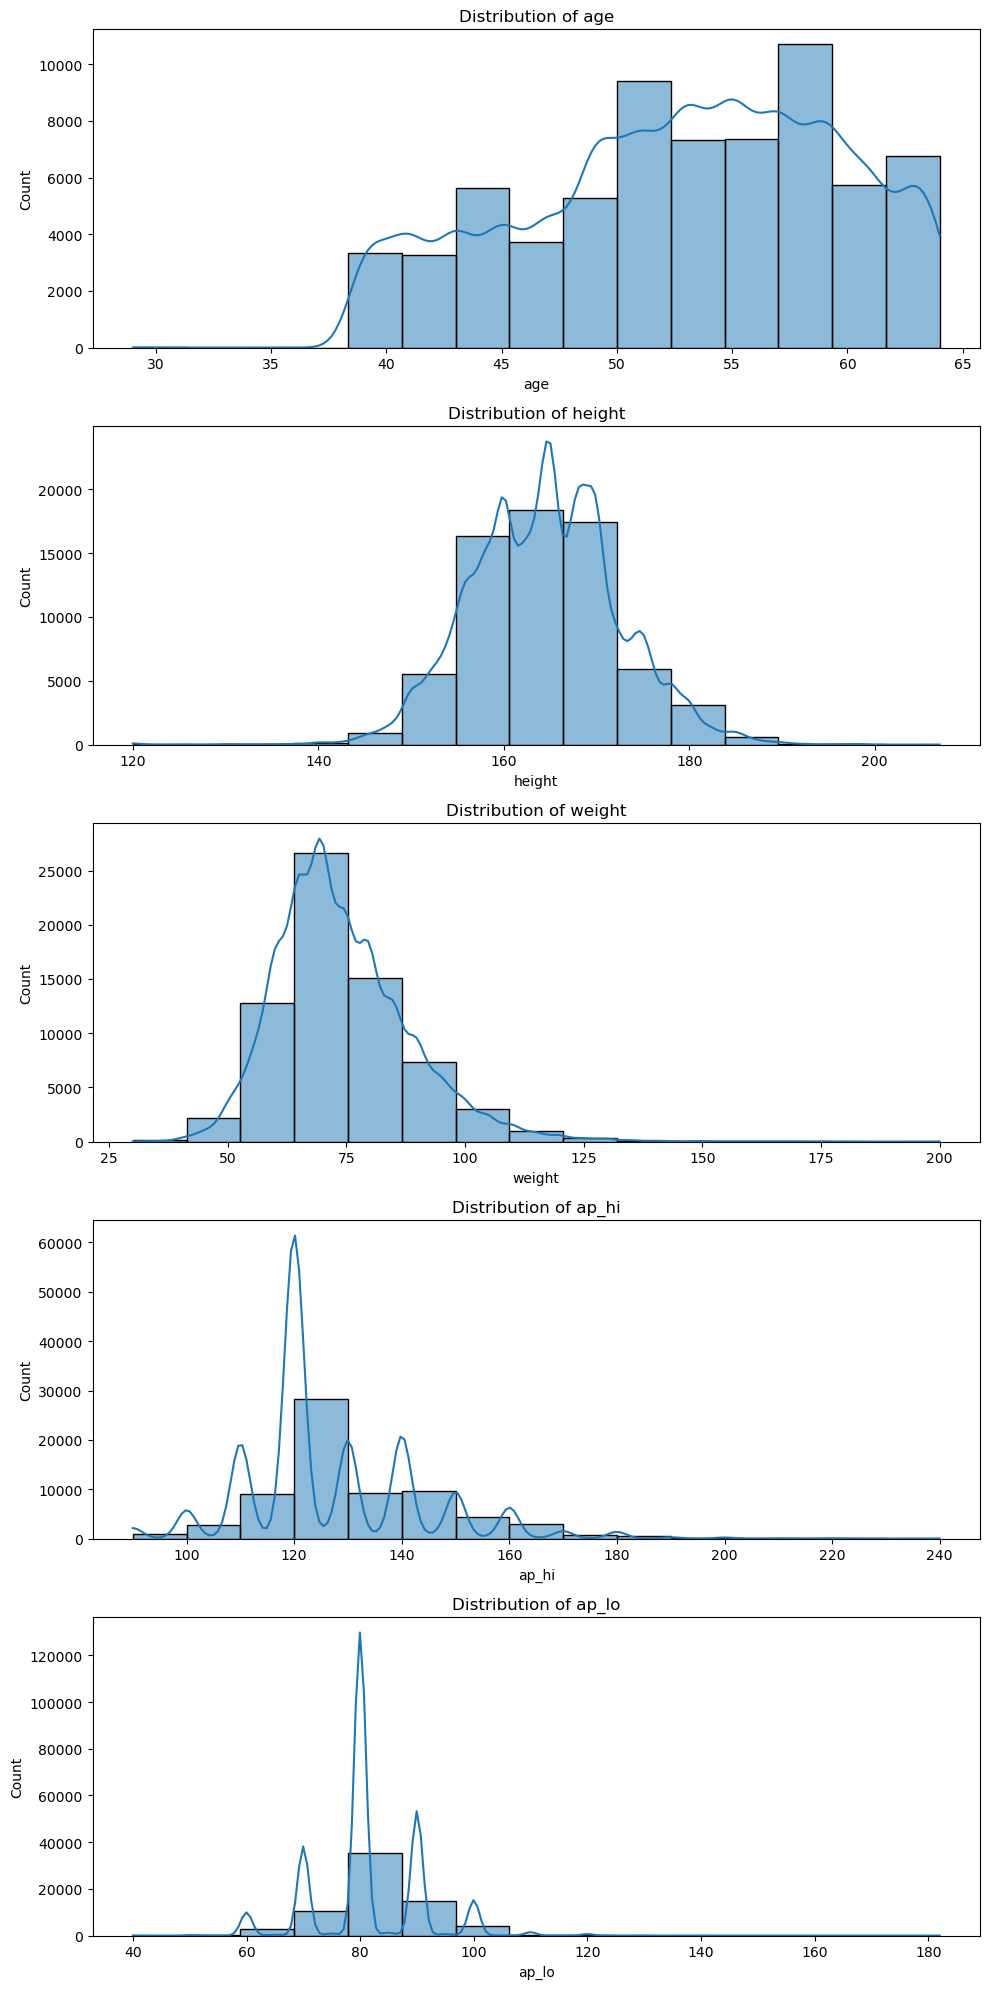

In [200]:
fig, axes = plt.subplots(len(numerical_cols_list), 1, figsize=(10, 20), tight_layout=True)

for col, ax in zip(numerical_cols_list, axes):
    sns.histplot(data=df, x=col, bins=15, kde=True, ax=ax) 
    ax.set_title(f'Distribution of {col}')

plt.show()

In [201]:
# Correlation matrix for numerical columns
correlation = numerical_cols.drop('cardio',axis=1).corr()
correlation

,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.085817,0.054642,0.209029,0.155682
height,-0.085817,1.000000,0.306223,0.017133,0.035322
weight,0.054642,0.306223,1.000000,0.269393,0.252191
ap_hi,0.209029,0.017133,0.269393,1.000000,0.732878
ap_lo,0.155682,0.035322,0.252191,0.732878,1.000000


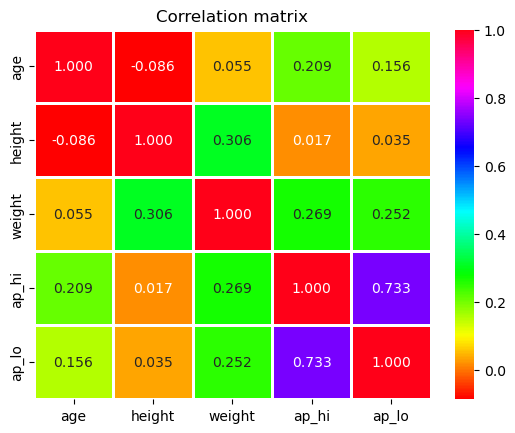

In [202]:
sns.heatmap(correlation,annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.title("Correlation matrix")
plt.show()

##### Observations
1. Strong Correlation Between `ap_hi` and `ap_lo`:

- Correlation coefficient = `0.733`.
- This strong positive correlation is expected, as systolic and diastolic blood pressures are physiologically related.

2. Moderate Correlations:
`weight` shows moderate positive correlations with: 
- `height` (0.306): Taller individuals generally weigh more.
- `ap_hi` (0.270) and `ap_lo` (0.252): Higher weight is often associated with elevated blood pressure.

3. Weak Correlations:
`age` is weakly correlated with:
- `ap_hi` (0.209): Older individuals may have slightly higher systolic blood pressure.
- `ap_lo` (0.156): A similar trend for diastolic blood pressure.
- `age` and `weight` (0.055): Minimal association between age and weight.
- `height` and` blood pressure` (`ap_hi`: 0.017, `ap_lo`: 0.035): Negligible correlation between height and blood pressure.

4. Negative Correlations:
- `age` and `height` (-0.086): A weak negative correlation indicates older individuals may tend to be shorter, possibly due to age-related changes like bone density loss.

**Note**: Given the weak relationships, I will use more complex, non-linear analysis techniques, as linear models may not capture significant patterns effectively.

Therefore my choice is to test
1. Decision tree
2. Random forest
3. XGBoost

The best performing model will then be based on the best prediction performance.

In [203]:
# Analyzing categorical Features
categorical_cols = list(df.select_dtypes(include=['object']).columns.values)
categorical_cols.append('cardio')
categorical_cols

['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

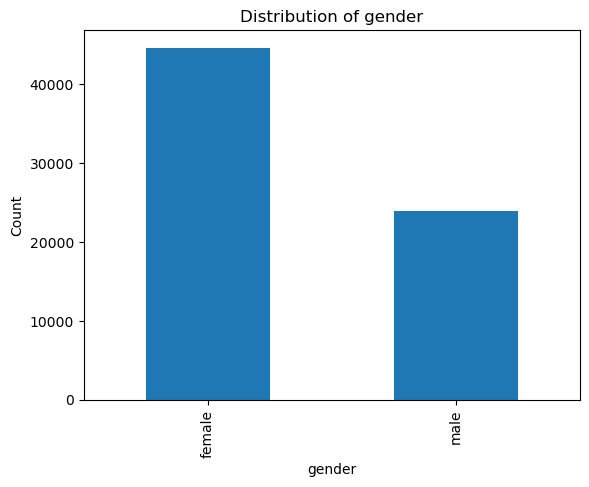

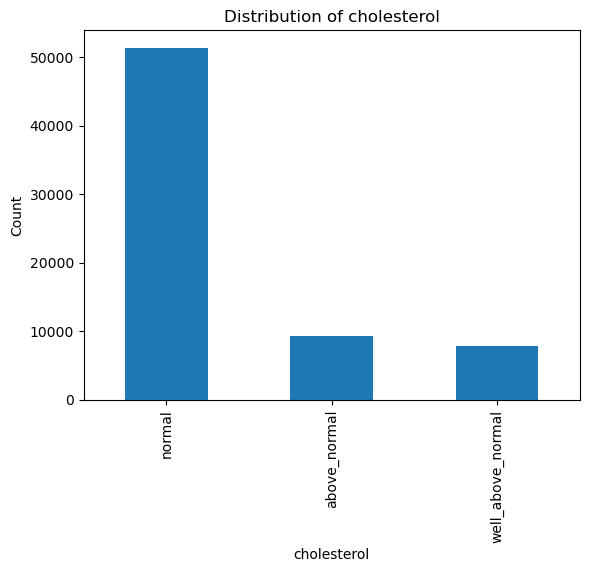

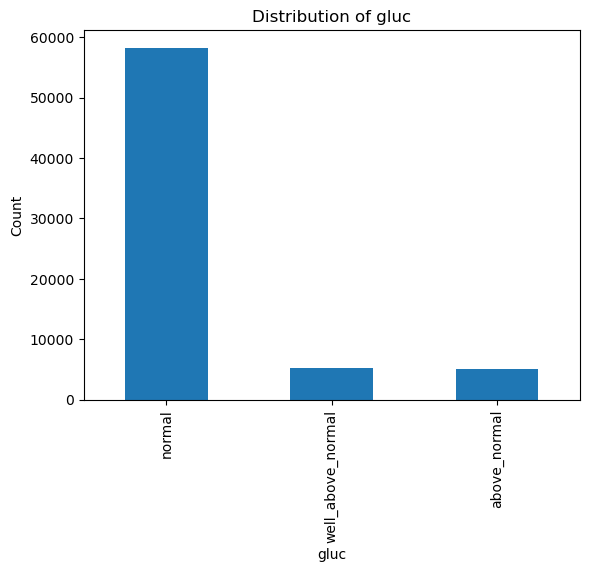

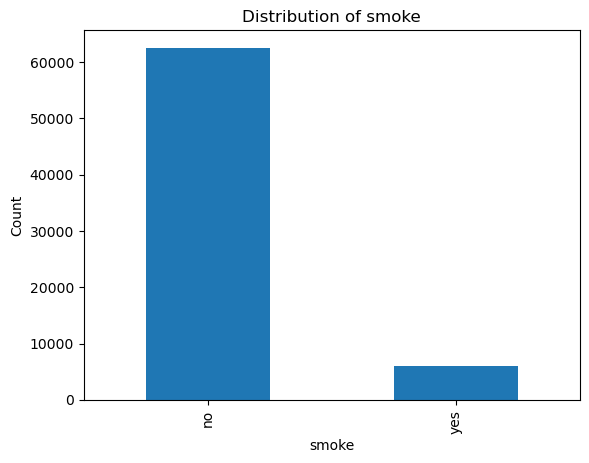

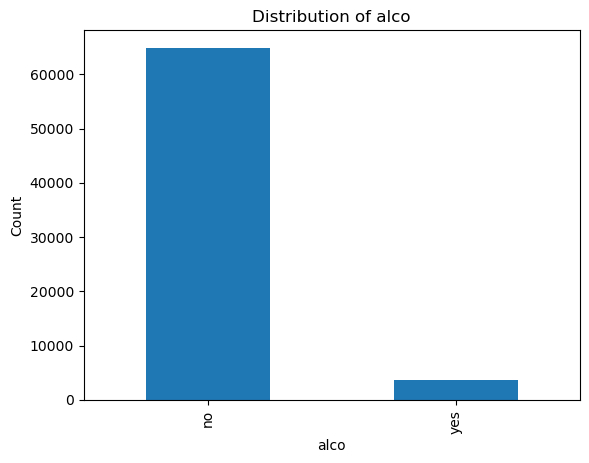

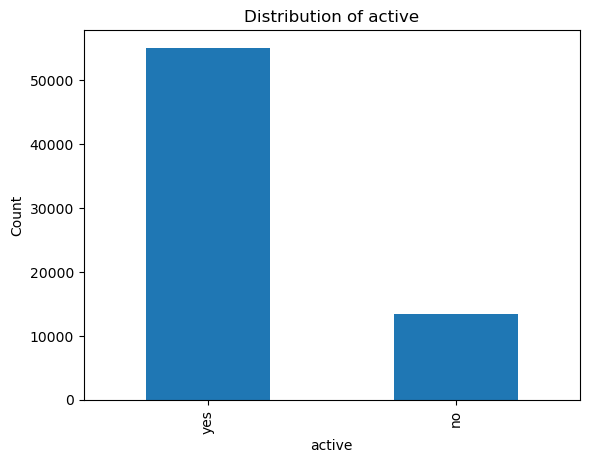

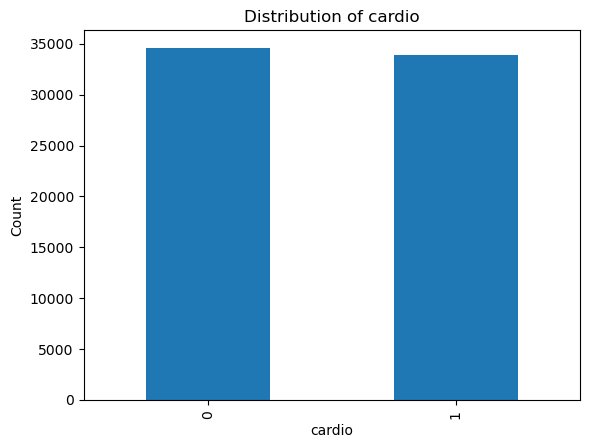

In [204]:
# Plot barcharts for categorical features
for col in categorical_cols:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

## Data Pre-processing
Split dataset into
1. Full Training dataset (80% of dataset) 
2. Training dataset (60% of Dataset)
3. Validation set (20% of Dataset)
4. Testing set (20% of Dataset)

In [205]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1,shuffle=True)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1,shuffle=True)

In [206]:
df_full_train.shape,df_train.shape,df_val.shape,df_test.shape

((54835, 12), (41126, 12), (13709, 12), (13709, 12))

In [207]:
# Define Training features and prediction values
y_train = df_train.cardio.values
y_val = df_val.cardio.values
y_test = df_test.cardio.values
y_full_train = df_full_train.cardio.values

df_full_train = df_full_train.drop('cardio',axis=1)
df_train = df_train.drop('cardio',axis=1)
df_val = df_val.drop('cardio',axis=1)
df_test = df_test.drop('cardio',axis=1)

### Onehot encoding
- `X_train` - Feature matrix
- `X_val` - Validation matrix
- `y_train` - training target vairable
- `y_val` - validation target vairable
- `y_test` - testing target vairable

In [208]:
dict_full_train = df_full_train.to_dict(orient='records')
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')

In [209]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_train = dv.fit_transform(dict_train)
X_val = dv.fit_transform(dict_val)
X_test = dv.fit_transform(dict_test)

### Decision Trees

In [210]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [211]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_pred)

0.9993908096140856

In [212]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.6297468677765241

Overfitting detected

#### Decision tree Parameter tuning
1. `max_depth` - Control the maximum depth of the tree, minimizing complex patterns that might overfit the data
2. `min_samples_split`- Minimum number of samples required to split the internal node
3. `min_samples_leaf` - Minimum number of samples required to split an internal node

In [213]:
max_depths = np.arange(1,20,1)
scores = []
for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth,)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    scores.append((depth,auc))

In [214]:
df_scores = pd.DataFrame(scores,columns=['depth','auc'])
df_scores.sort_values('auc',ascending=False)

,depth,auc
5,6,0.793204
6,7,0.791713
4,5,0.791217
7,8,0.789335
8,9,0.786705
3,4,0.785966
2,3,0.777953
9,10,0.777162
10,11,0.769983
1,2,0.762002


Text(0, 0.5, 'ROC area under curve')

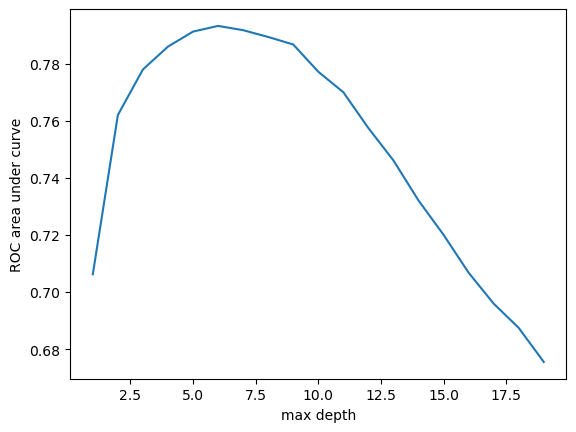

In [215]:
plt.plot(df_scores.depth,df_scores.auc)
plt.xlabel('max depth')
plt.ylabel('ROC area under curve')

Best max_depth - 6 prediction - 0.793204

In [217]:
min_samples = np.arange(1,200,1)
scores = []
for leaf in min_samples:
    dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=leaf)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    scores.append((leaf,6,auc))

In [218]:
df_scores = pd.DataFrame(scores,columns=['leaf','depth','auc'])

In [219]:
df_scores.sort_values('auc',ascending=False)

,leaf,depth,auc
186,187,6,0.794098
187,188,6,0.794098
184,185,6,0.794098
185,186,6,0.794098
183,184,6,0.794098
...,...,...,...
3,4,6,0.793208
12,13,6,0.793206
0,1,6,0.793204
5,6,6,0.793054


Best Max Samples Leaf - 187, prediction - 0.794098

In [221]:
dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=187)
dt.fit(X_train,y_train)
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7940976229942853

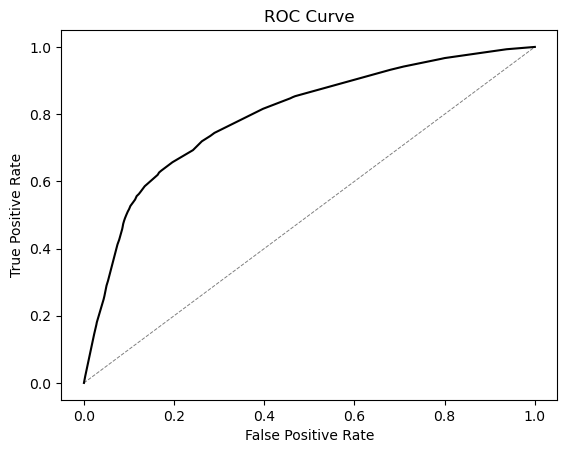

In [222]:
fpr,tpr,_ = roc_curve(y_val,y_pred)
plt.plot(fpr,tpr,color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Random Forest
- `rf` - Random Forest classifier instance
- `n_estimators` - Number of trees in the forest
- `n_jobs` - The number of jobs to run in parallel
- `max_depth` - The maximum depth of the tree.
- `min_leaf_size` - The minimum number of samples required to be at a leaf node. 

In [223]:
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [224]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.7465944828523388

In [225]:
aucs = []

for i in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)
    aucs.append((i,auc))

In [226]:
df_aucs= pd.DataFrame(aucs,columns=['n_estimator','auc'])
df_aucs.sort_values('auc',ascending=False)

,n_estimator,auc
17,180,0.764195
19,200,0.763773
18,190,0.763553
13,140,0.763529
14,150,0.763328
11,120,0.763077
12,130,0.762983
16,170,0.762927
8,90,0.762782
15,160,0.762585


Best N Estimator value - 180

Text(0.5, 1.0, 'Number of trees vs. AUC')

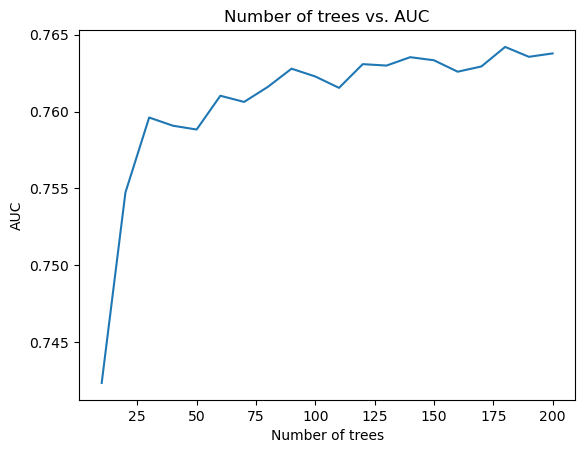

In [227]:
# Visualizing the n_estimatoes
plt.plot(df_aucs.n_estimator,df_aucs.auc)
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.title('Number of trees vs. AUC')

##### parameter tuning - Random forest
- `max_depth`
- `min_leaf_size`

In [228]:
auc_cal = {}

for depth in range(2,11,2):
    print(f'depth: {depth}')
    aucs = []
    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=depth,random_state=1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        aucs.append((auc))
    auc_cal[depth] = aucs

depth: 2
depth: 4
depth: 6
depth: 8
depth: 10


In [229]:
auc_cal

{2: [0.7752999291084006,
  0.7806920351764014,
  0.7813907018591887,
  0.7817751095558743,
  0.7826170005139343,
  0.7826169685846168,
  0.7817583253779665,
  0.7805766213366855,
  0.7800634001300333,
  0.7801913089760036,
  0.7809061212503486,
  0.7807630779078752,
  0.7810371698125417,
  0.7803517005809943,
  0.7804761184882498,
  0.7800540767693184,
  0.7802677690483496,
  0.7807077550437252,
  0.7804486060596565,
  0.7810598396279783],
 4: [0.7860905377510112,
  0.7876749449879145,
  0.7887548902942708,
  0.7901364505769926,
  0.7899884262609868,
  0.7900204087940322,
  0.7902981619271072,
  0.7902288433787792,
  0.7902006497914121,
  0.7905395475675309,
  0.7905647291559456,
  0.7905971054839072,
  0.7903047712958331,
  0.7900253578382472,
  0.7897982126734358,
  0.7897386644962677,
  0.7897126208162804,
  0.7897752448510358,
  0.7897283193973924,
  0.7899488764796897],
 6: [0.7958723396066921,
  0.7965336277017736,
  0.7960349130483797,
  0.7960859467408766,
  0.7963259487775414,

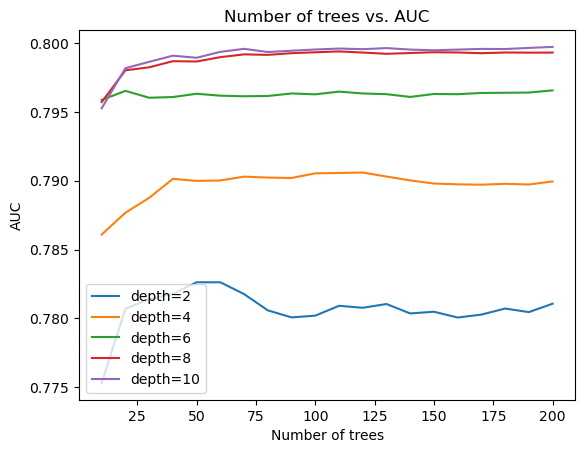

In [230]:
n_trees = list(range(10,201,10))
for i,_ in auc_cal.items():
    plt.plot(n_trees,auc_cal[i],label='depth=%s'% i)
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')
    plt.title('Number of trees vs. AUC')
    plt.legend()

Best `max_depth` = 10 with auc about `79.99%`

In [231]:
auc_cal = {}

for m in [10,6,7]:
    print(f'min_samples_leaf: {m}')
    aucs = []
    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=m)
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)
        aucs.append((auc))
    auc_cal[m] = aucs

min_samples_leaf: 10
min_samples_leaf: 6
min_samples_leaf: 7


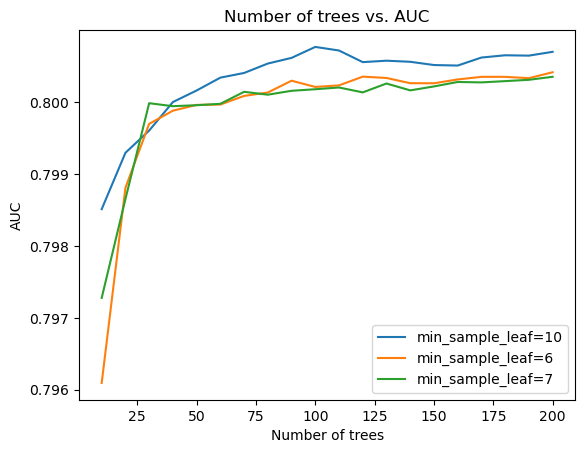

In [232]:
n_trees = list(range(10,201,10))
for i in list(auc_cal.keys()):
    plt.plot(n_trees,auc_cal[i],label='min_sample_leaf=%s'% i)
    plt.xlabel('Number of trees')
    plt.ylabel('AUC')
    plt.title('Number of trees vs. AUC')
    plt.legend()

In [233]:
df_aucs_rf = pd.DataFrame(auc_cal)
df_aucs_rf.sort_values(by=[10,6,7],ascending=False)

,10,6,7
9,0.800765,0.800209,0.800177
10,0.800715,0.800231,0.800201
19,0.800697,0.800413,0.800350
17,0.800649,0.800349,0.800290
18,0.800644,0.800331,0.800308
16,0.800617,0.800349,0.800272
8,0.800613,0.800295,0.800155
12,0.800573,0.800334,0.800256
13,0.800558,0.800261,0.800161
11,0.800554,0.800352,0.800133


Random Forest Parameters
- `max_depth` - 10
- `n_estimators` - 180
- `min_samples_leaf` - 10

In [266]:
# Final Random Forest model
rf = RandomForestClassifier(n_estimators=180,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=10)
rf.fit(X_train,y_train)
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_pred)

0.800648859076083

#### Gradient Boosting with XG-BOOST
I will combine multiple models together in an ensemble.

- `dtrain` - Training dataset
- `xgb_params` - Training parameters
- `num_boost_round`- Number of trees to train
- `evals` - Triggers the watchlist
- `verbose_eval` - How often the metric is printed

In [237]:
dfulltrain = xgboost.DMatrix(X_full_train,label=y_full_train,feature_names=list(dv.get_feature_names_out()))
dtrain = xgboost.DMatrix(X_train,label=y_train,feature_names=list(dv.get_feature_names_out()))
dval = xgboost.DMatrix(X_val,label=y_val,feature_names=list(dv.get_feature_names_out()))
dtest = xgboost.DMatrix(X_test,label=y_test,feature_names=list(dv.get_feature_names_out()))

In [238]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

In [239]:
model = xgboost.train(xgb_params,dtrain,num_boost_round=10)

In [240]:
y_pred = model.predict(dval)
roc_auc_score(y_val,y_pred)

0.8002701986565505

`watchlist = [(dtrain, 'train'), (dval, 'val')]`

In [241]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [242]:
%%capture output
model = xgboost.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist,verbose_eval=10)

In [243]:
def gradient_boost_output(output):
    data = []
    for i in output.stdout.split('\n'):
        if i:
            line = i.split('\t')
            round_num = int(line[0].strip('[]'))
            train_auc = float(line[1].split(":")[1])
            val_auc = float(line[2].split(":")[1])
            data.append((round_num, train_auc, val_auc))
    return data

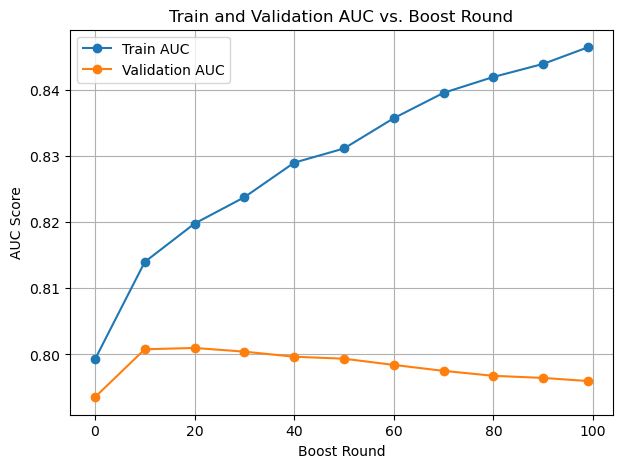

In [244]:
# Convert to DataFrame
df_grad_boost = pd.DataFrame(gradient_boost_output(output), columns=["boost_round", "train_auc", "val_auc"])

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(df_grad_boost["boost_round"], df_grad_boost["train_auc"], label="Train AUC", marker='o')
plt.plot(df_grad_boost["boost_round"], df_grad_boost["val_auc"], label="Validation AUC", marker='o')
plt.xlabel("Boost Round")
plt.ylabel("AUC Score")
plt.title("Train and Validation AUC vs. Boost Round")
plt.legend()
plt.grid(True)
plt.show()

In [245]:
df_grad_boost.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
2,20,0.81981,0.80098
1,10,0.81400,0.80078
3,30,0.82380,0.80042
4,40,0.82903,0.79965
5,50,0.83118,0.79935


Each model in gradient boosting tries to fix mistakes of the previos boosting step. However, as seen in the validation scores above, the scores rise but then start to decline. This is an effect of `overfitting`.

##### XGBoost Parameter Tuning
Parameters of focus
- `eta` - Learning rate
- `max_depth` - Max allowed depth for each tree
- `min_child_weight` - minimum number of observations in each group == `min_leaf_size`

In [246]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

##### **ETA** parameter tuning
- Values - [`0.05`,`0.1`,`0.2`,`0.3`]
- boost rounds - 500

In [247]:
%%capture model_output_0_1
model = xgboost.train(xgb_params,dtrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

In [248]:
df_grad_boost_0_1 = pd.DataFrame(gradient_boost_output(model_output_0_1), columns=["boost_round", "train_auc", "val_auc"])
# Plotting
df_grad_boost_0_1.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
6,60,0.82089,0.80110
4,40,0.81675,0.80102
12,120,0.82804,0.80101
13,130,0.82900,0.80098
5,50,0.81921,0.80098


Best **validation** AUC - `80.11%` for `auc = 0.1` after `60` iterations

In [249]:
xgb_params = {
    'eta': 0.2,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

In [250]:
%%capture model_output_0_2
model = xgboost.train(xgb_params,dtrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

In [251]:
df_grad_boost_0_2 = pd.DataFrame(gradient_boost_output(model_output_0_2), columns=["boost_round", "train_auc", "val_auc"])
# Plotting
df_grad_boost_0_2.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
4,40,0.82119,0.80128
3,30,0.81929,0.80123
2,20,0.81655,0.80111
5,50,0.82503,0.80065
6,60,0.82765,0.80061


Best **validation** **AUC** - `80.128%` for `auc=0.2` after `40` iterations

In [252]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

In [253]:
%%capture model_output_0_0_5
model = xgboost.train(xgb_params,dtrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

In [254]:
df_grad_boost_0_0_5 = pd.DataFrame(gradient_boost_output(model_output_0_0_5), columns=["boost_round", "train_auc", "val_auc"])
# Plotting
df_grad_boost_0_0_5.sort_values(by=['val_auc'],ascending=False).head()

,boost_round,train_auc,val_auc
17,170,0.82317,0.80122
14,140,0.82157,0.80122
16,160,0.82275,0.80118
15,150,0.82220,0.80117
18,180,0.82395,0.80114


Best **validation AUC** - `80.122%` for `auc=0.05` after `170` iterations

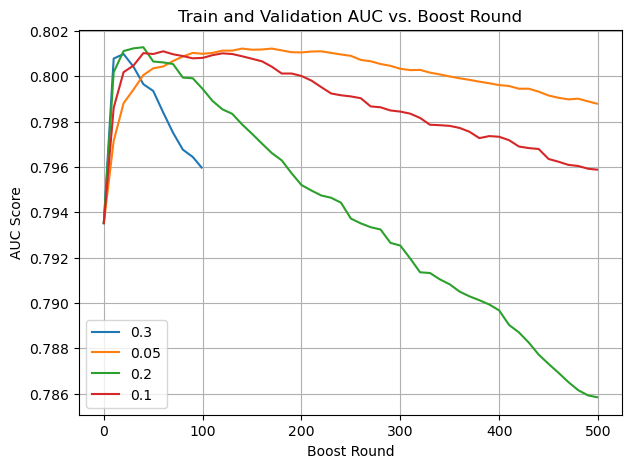

In [255]:
# Plotting all 4 eta curves
plt.figure(figsize=(7, 5))
plt.plot(df_grad_boost["boost_round"], df_grad_boost["val_auc"], label="0.3")
plt.plot(df_grad_boost_0_0_5["boost_round"], df_grad_boost_0_0_5["val_auc"], label="0.05")
plt.plot(df_grad_boost_0_2["boost_round"], df_grad_boost_0_2["val_auc"], label="0.2")
plt.plot(df_grad_boost_0_1["boost_round"], df_grad_boost_0_1["val_auc"], label="0.1")
plt.xlabel("Boost Round")
plt.ylabel("AUC Score")
plt.title("Train and Validation AUC vs. Boost Round")
plt.legend()
plt.grid(True)
plt.show()

- `eta=0.1` presents `80.11%` after `60` iterations
- `eta=0.05` presents `80.122%` after `170` iterations
- `eta=0.2` presents`80.128%` after `40` iterations
- `eta=0.3` presents `80.027%` after `20` iterations

**Findings**
- eta of `0.2` presents almost similar results to eta of `0.2` but after `40` more iterations
- eta of `0.3` presents the least result of all.

### `max_depth`, `eta`, `min_child_weight` gradient boost parameters combined

In [256]:
val_aucs  = []

etas = [0.05, 0.1, 0.2, 0.3]
max_depths = [4, 5, 6]
min_child_weights = range(15,17,1)

for eta in etas:
    for depth in max_depths:
        for min_child_weight in min_child_weights:
            xgb_params = {
                'eta': eta,
                'max_depth': depth,
                'min_child_weight': min_child_weight,
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'seed': 1,
            }
            
             # Capture model output
            f = io.StringIO()
            with contextlib.redirect_stdout(f):
                model = xgboost.train(xgb_params,dtrain,num_boost_round=200,evals=watchlist,verbose_eval=10)
        
            # Extract AUC values from the captured output
            output = f.getvalue().splitlines()
            depth_val_aucs = []
            for line in output:
                match = re.search(r"\[(\d+)\]\s+train-auc:[0-9.]+\s+val-auc:([0-9.]+)", line)
                if match:
                    boost_round = int(match.group(1))
                    val_auc = float(match.group(2))
                    depth_val_aucs.append((boost_round, val_auc))
            
            # Store AUCs and depth information in aucs list
            val_aucs.append({
                "eta": eta,
                "depth": depth,
                "min_child_weight": min_child_weight,
                "val_auc": depth_val_aucs
            })

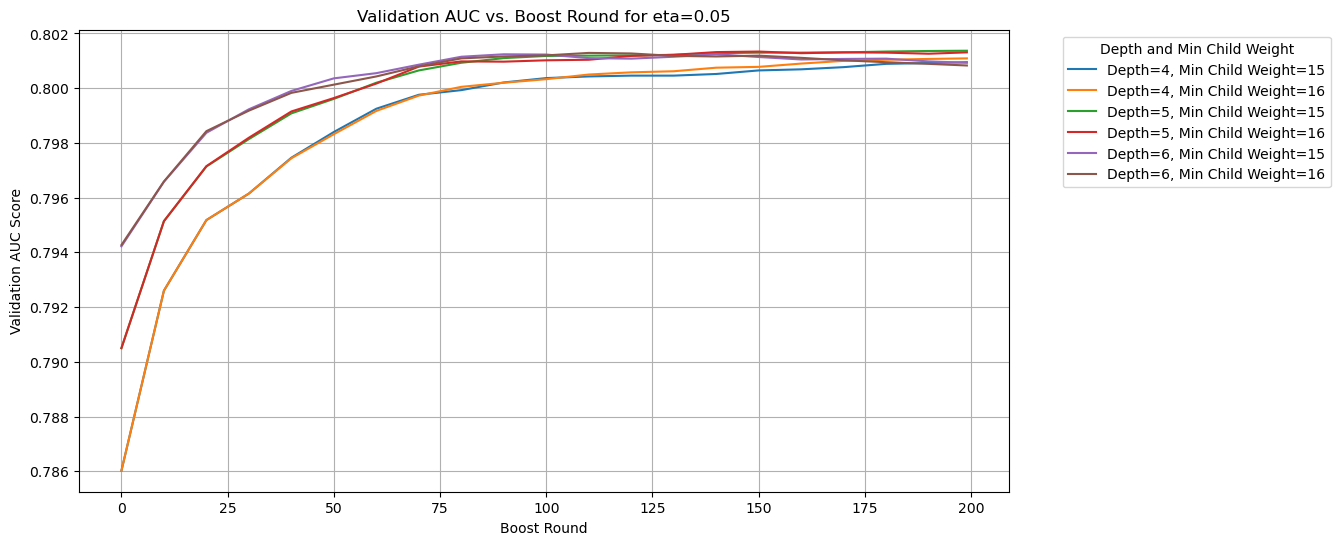

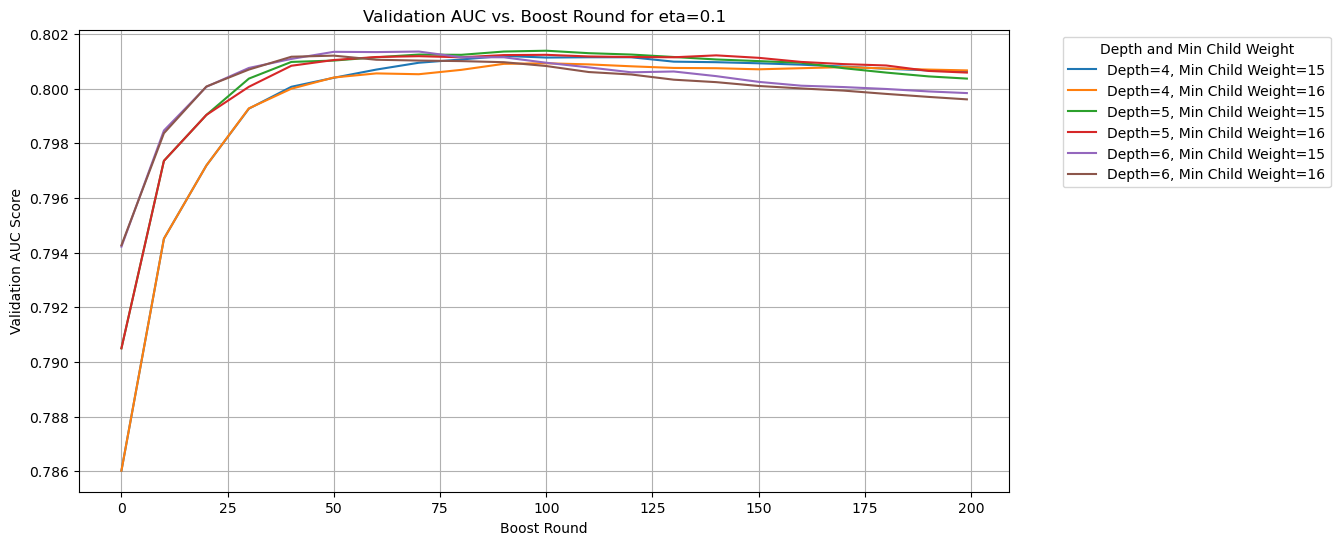

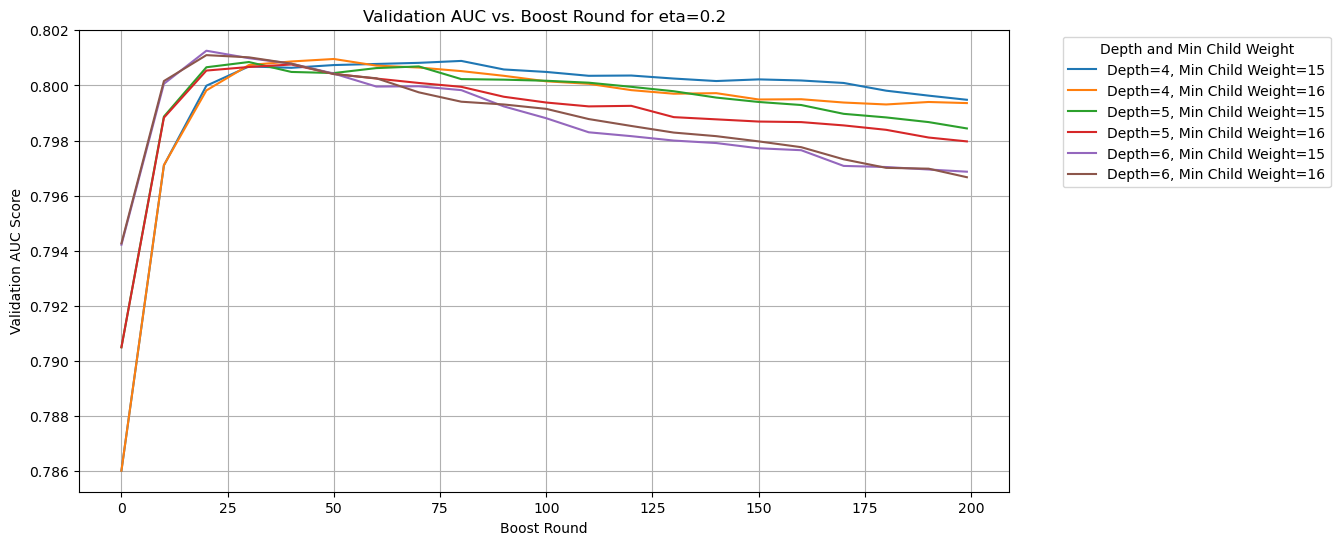

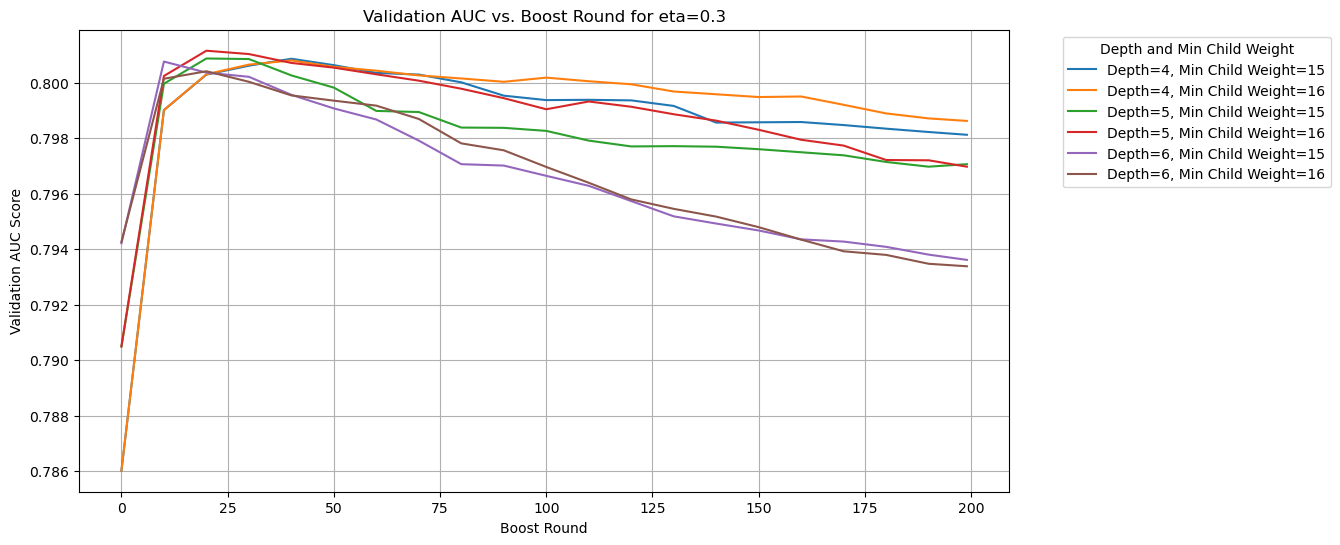

In [258]:
plot_data = []
for entry in val_aucs:
    eta = entry["eta"]
    depth = entry["depth"]
    min_child_weight = entry["min_child_weight"]
    
    for boost_round, val_auc in entry["val_auc"]:
        plot_data.append((eta,depth,min_child_weight, boost_round, val_auc))

df_boost_depth = pd.DataFrame(plot_data, columns=["eta", "depth","min_child_weight", "boost_round", "val_auc"])

# Plotting
for eta in etas:
    plt.figure(figsize=(12, 6))
    subset_eta = df_boost_depth[df_boost_depth['eta'] == eta]
    for depth in subset_eta['depth'].unique():
        for min_child_weight in subset_eta['min_child_weight'].unique():
            subset = subset_eta[(subset_eta['depth'] == depth) & (subset_eta['min_child_weight'] == min_child_weight)]
            if not subset.empty:  # Ensure there's data to plot
                plt.plot(subset['boost_round'], subset['val_auc'], label=f"Depth={depth}, Min Child Weight={min_child_weight}")
    
    plt.xlabel("Boost Round")
    plt.ylabel("Validation AUC Score")
    plt.title(f"Validation AUC vs. Boost Round for eta={eta}")
    plt.legend(title="Depth and Min Child Weight", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()

In [259]:
df_boost_depth.sort_values('val_auc',ascending=False)

,eta,depth,min_child_weight,boost_round,val_auc
178,0.10,5,15,100,0.80139
62,0.05,5,15,199,0.80137
177,0.10,5,15,90,0.80136
217,0.10,6,15,70,0.80136
61,0.05,5,15,190,0.80136
...,...,...,...,...,...
273,0.20,4,16,0,0.78602
147,0.10,4,16,0,0.78602
126,0.10,4,15,0,0.78602
21,0.05,4,16,0,0.78602


Best **Gradient Boost Model** - `80.139%`
- `eta` - 0.1
- `depth` - 5
- `min_child_weight` - 15
- `boost_round` - 100

## Final Models
- Final model choice after parameter tuning

In [260]:
def evaluate_model(y_test, y_pred, y_pred_proba, model_name):
    # AUC-ROC Score
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name} - AUC-ROC Score: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.4f}")

    # Precision, Recall, F1 Score
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

### Models

In [274]:
# Decision tree
clf_dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=187)
clf_dt.fit(X_full_train,y_full_train)
y_pred_dt = clf_dt.predict(X_test)
y_pred_proba_dt = clf_dt.predict_proba(X_test)[:,1]

In [275]:
# Final Random Forest model
clf_rf = RandomForestClassifier(n_estimators=180,n_jobs=-1,max_depth=10,random_state=1,min_samples_leaf=10)
clf_rf.fit(X_full_train,y_full_train)
y_pred_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = clf_rf.predict(X_test)

### Final Evaluations of the models

Decision Tree - AUC-ROC Score: 0.7920


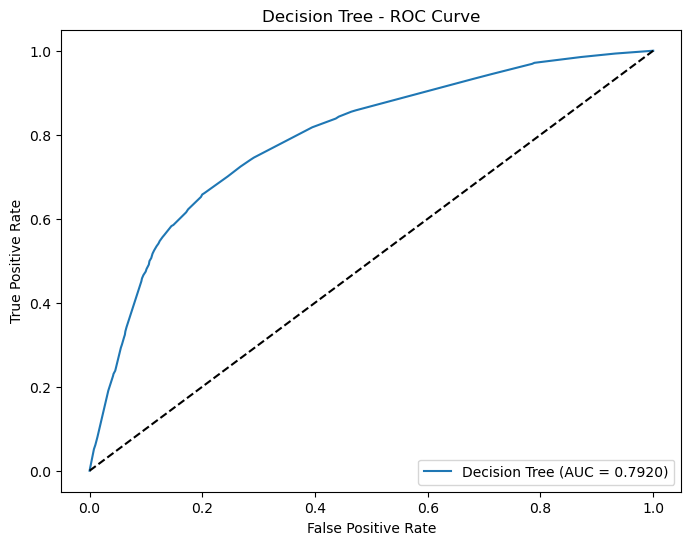

Decision Tree - Accuracy: 0.7305

Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75      7011
           1       0.76      0.66      0.70      6698

    accuracy                           0.73     13709
   macro avg       0.73      0.73      0.73     13709
weighted avg       0.73      0.73      0.73     13709



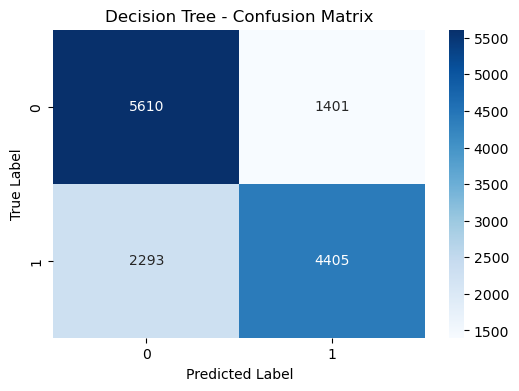

In [276]:
# For Decision Tree
evaluate_model(y_test, y_pred_dt, y_pred_proba_dt, "Decision Tree")

Random Forest - AUC-ROC Score: 0.7998


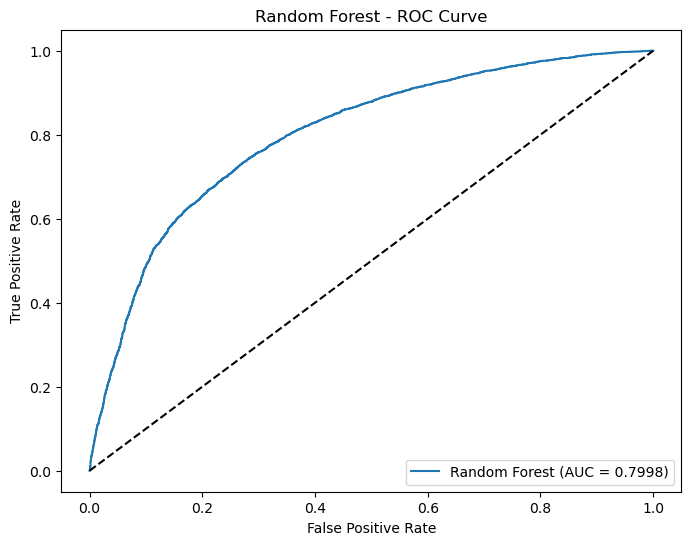

Random Forest - Accuracy: 0.7276

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      7011
           1       0.75      0.66      0.70      6698

    accuracy                           0.73     13709
   macro avg       0.73      0.73      0.73     13709
weighted avg       0.73      0.73      0.73     13709



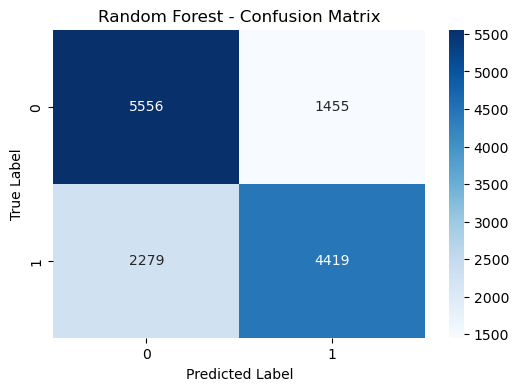

In [277]:
# For Random Forest
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, "Random Forest")

In [282]:
%%capture
xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 15,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 1,
}

model = xgboost.train(xgb_params,dfulltrain,num_boost_round=500,evals=watchlist,verbose_eval=10)

XGBoost - AUC-ROC Score: 0.7997


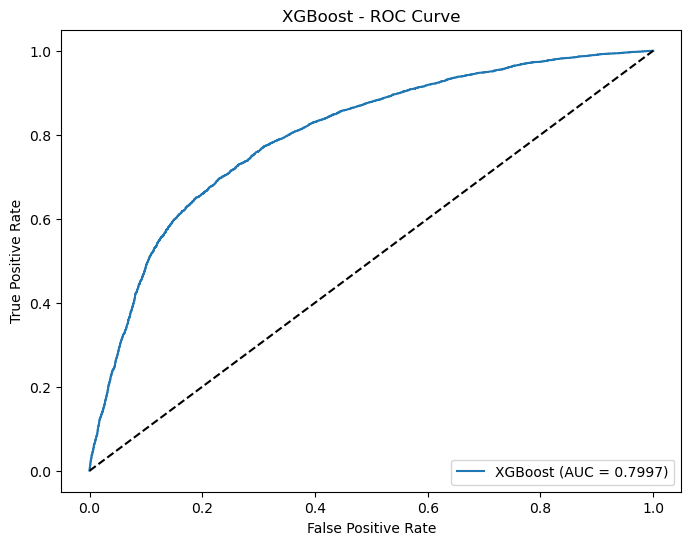

XGBoost - Accuracy: 0.7319

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      7011
           1       0.75      0.69      0.71      6698

    accuracy                           0.73     13709
   macro avg       0.73      0.73      0.73     13709
weighted avg       0.73      0.73      0.73     13709



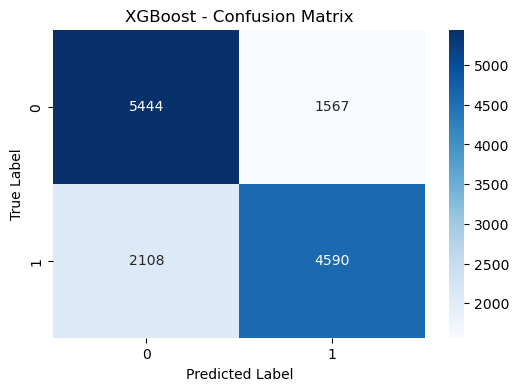

In [279]:
y_pred_proba_xgb = model.predict(dtest)
y_pred_xgb = (y_pred_proba_xgb > 0.5).astype(int)

evaluate_model(y_test,y_pred_xgb,y_pred_proba_xgb,"XGBoost")

Sample out test subjects from df_test

In [280]:
data = df.sample().to_dict(orient='records')[0]
data

{'age': 55,
 'gender': 'male',
 'height': 170,
 'weight': 86.0,
 'ap_hi': 140.0,
 'ap_lo': 90.0,
 'cholesterol': 'normal',
 'gluc': 'normal',
 'smoke': 'no',
 'alco': 'no',
 'active': 'yes',
 'cardio': 1}

In [281]:
import requests

payload = {'age': 15327,
 'gender': 'female',
 'height': 168,
 'weight': 98.0,
 'ap_hi': 150,
 'ap_lo': 99,
 'cholesterol': 'above_normal',
 'gluc': 'normal',
 'smoke': 'no',
 'alco': 'no',
 'active': 'no'
 }

res = requests.post('http://localhost:5050/',json=payload)
res.raise_for_status()

res.json()

{'prediction': 0.9076,
 'cardio': True,
 'prediction%': '90.75999999999999%',
 'threshold': 0.5}